In [40]:
import pyfits
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.io import fits
import scipy.ndimage as snd
import scipy
%matplotlib inline

[ '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/BIAS/Bias.00000001.M_51.BIAS.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/BIAS/Bias.00000002.M_51.BIAS.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/BIAS/Bias.00000003.M_51.BIAS.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/BIAS/Bias.00000004.M_51.BIAS.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/BIAS/Bias.00000005.M_51.BIAS.FIT'] ... [ '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/Test images/TEST.00000022.SAO_62802.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/Test images/TEST.00000023.SAO_62802.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/Test images/TEST.00000024.SAO_62802.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/Test images/TEST.00000025.SAO_62802.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/Test imag

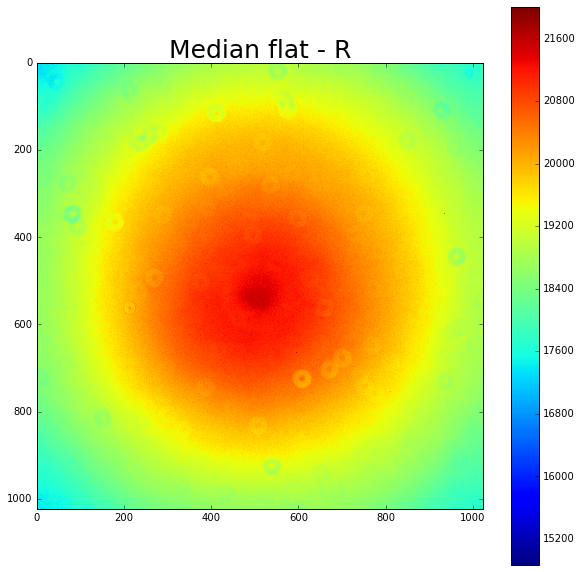

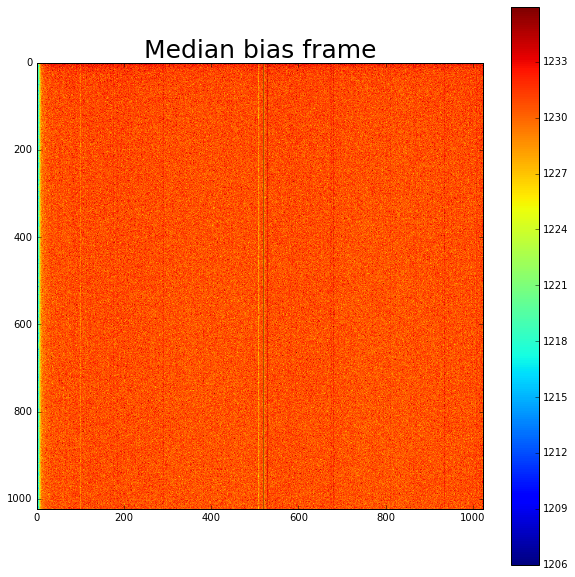

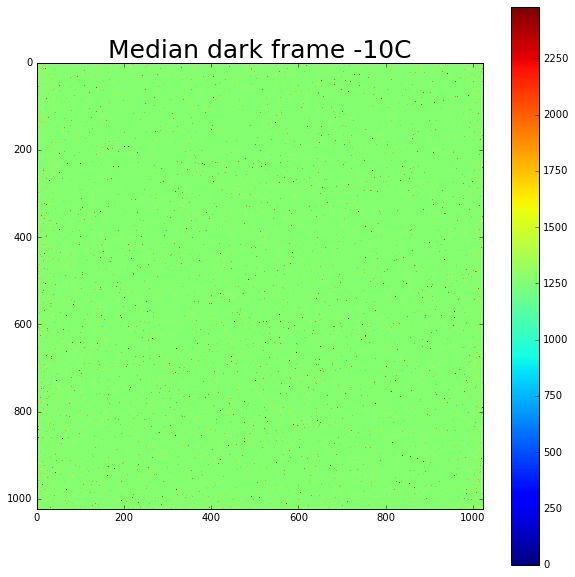

In [91]:
"""
Fit files from 2016

Using getheader to differenciate filetypes

"""

rootdir='/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/'
all_fits_filenames=np.array(glob.glob(rootdir+'*/*.FIT'))
print all_fits_filenames[:5],"...",all_fits_filenames[-5:]

all_exp_types = np.array([pyfits.getheader(fooname)["IMAGETYP"] for fooname in all_fits_filenames])
print "Our exposure types",np.unique(all_exp_types)

light_filenames = all_fits_filenames[np.where(all_exp_types=='Light Frame')]
light_folders = np.array([fooname.split('/')[-2] for fooname in light_filenames])

bias_filenames = all_fits_filenames[np.where(all_exp_types=='Bias Frame')]
print "Number of bias frames",len(bias_filenames)

dark_filenames = np.sort(all_fits_filenames[np.where(all_exp_types=='Dark Frame')])
dark_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in dark_filenames])
dark_temperature=np.array([pyfits.getheader(fooname)["CCD-TEMP"] for fooname in dark_filenames])
print "Number of darks and exposure times",str(len(dark_filenames)),np.unique(dark_exptimes)
print "Temperatures",str(len(dark_filenames)),np.unique(dark_temperature)

flat_filenames = light_filenames[np.where(light_folders=='FLATS')]
flat_filter_names=np.array([pyfits.getheader(fooname)["FILTER"] for fooname in flat_filenames])
flat_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in flat_filenames])
print "Flat filters and exposure times",np.unique(flat_filter_names),np.unique(flat_exptimes)

light_filenames = all_fits_filenames[np.where(all_exp_types=='Light Frame')]
light_folders = np.array([fooname.split('/')[-2] for fooname in light_filenames])

m51_filenames=light_filenames[np.where(light_folders=='M51')]

m51_filter_names=np.array([pyfits.getheader(fooname)["FILTER"] for fooname in m51_filenames])
m51_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in m51_filenames])
print "M51 filters exposed and exposure times",np.unique(m51_filter_names),np.unique(m51_exptimes)

M51_temperature=np.array([pyfits.getheader(fooname)["CCD-TEMP"] for fooname in m51_filenames])
print "Temperatures",str(len(m51_filenames)),np.unique(M51_temperature)
""""
Median Function & Images of Flats, Bias, and  Darks

"""

def median_combine(filelist):
    allimgs=[]
    for filename in filelist: allimgs.append(pyfits.getdata(filename))
    allimgs=np.array(allimgs)
    medianimg=np.median(allimgs,axis=0)
    return medianimg


thefilt='R'
flat_time=5
dark_time=300


median_dark=median_combine(dark_filenames[:][np.where((dark_exptimes==dark_time))])

median_flat=median_combine(flat_filenames[np.where((flat_filter_names==thefilt) & 
                                                             (flat_exptimes==flat_time))])
median_bias=median_combine(bias_filenames[:50])   # note that I take only the first 50 biases, to save time

print len(flat_filenames[np.where((flat_filter_names==thefilt) & 
                                                             (flat_exptimes==flat_time))])


plt.figure(figsize=(10,10))
plt.imshow(median_flat,vmax=np.median(median_flat)+3*np.std(median_flat))
plt.title('Median flat - '+thefilt,fontsize=25)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(median_bias,vmax=np.median(median_bias)+3*np.std(median_bias))
plt.title('Median bias frame',fontsize=25)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(median_dark,vmax=np.median(median_dark)+3*np.std(median_dark))
plt.title('Median dark frame -10C',fontsize=25)
plt.colorbar()


In [42]:
def reduce_raw_science_frames(science_filelist,median_bias,median_flat,median_dark):
    allreducedimgs=[]
    normed_flat=(median_flat-median_bias)/np.median(median_flat-median_bias)
    for filename in science_filelist: 
        science_frame=pyfits.getdata(filename)
        reduced_frame=(science_frame-median_dark)/normed_flat
        allreducedimgs.append(reduced_frame)
    allreducedimgs=np.array(allreducedimgs)
    return allreducedimgs

[ '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_R_300s.00000001.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_R_300s.00000002.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_R_300s.00000003.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_R_300s.00000004.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_R_300s.00000005.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_R_300s.00000006.M_51.FIT']
[ 300.  300.  300.  300.  300.  300.]
[3248.0, 3014.0, 2978.0, 2936.0, 2894.0, 2852.0]



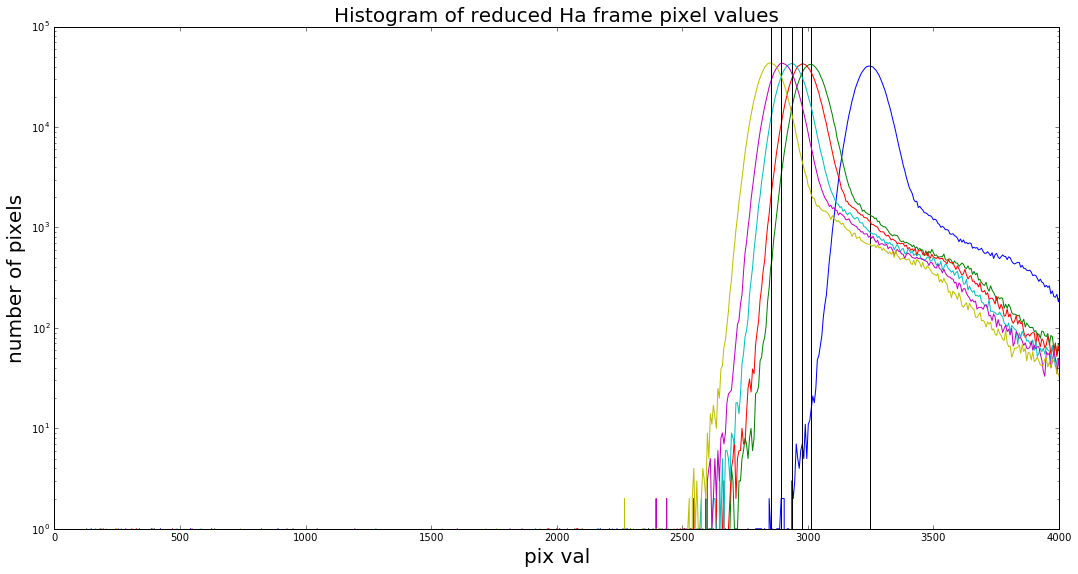

In [60]:
m51_time=300
science_filenames=np.sort(m51_filenames[np.where((m51_filter_names==thefilt) & (m51_exptimes==m51_time))])[1:]
science_filenames=science_filenames
print science_filenames
science_reduced = reduce_raw_science_frames(science_filenames,median_bias,median_flat,median_dark)
science_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in science_filenames])
print science_exptimes
for i in range(len(science_reduced)):
    pyfits.writeto(science_filenames[i].split('.FIT')[0]+'-reduced.fits',science_reduced[i],
                   clobber=True,header=pyfits.getheader(science_filenames[i]))

plt.figure(figsize=(18,9))
skylevels=[]
for i in range(len(science_reduced)):
    numpix,aduvals=np.histogram(science_reduced[i].flatten(),bins=1000,range=[-1000,5e3])
    skylevel=aduvals[np.where(numpix==numpix.max())][0]
    skylevels.append(skylevel)
    plt.plot(aduvals[:-1],numpix)
    plt.axvline(skylevel,color='k')
plt.xlabel('pix val',fontsize=20)
plt.ylabel('number of pixels',fontsize=20)
plt.yscale('log')

plt.xlim(0,4000)

print skylevels
plt.title('Histogram of reduced Ha frame pixel values',fontsize=20)

print 



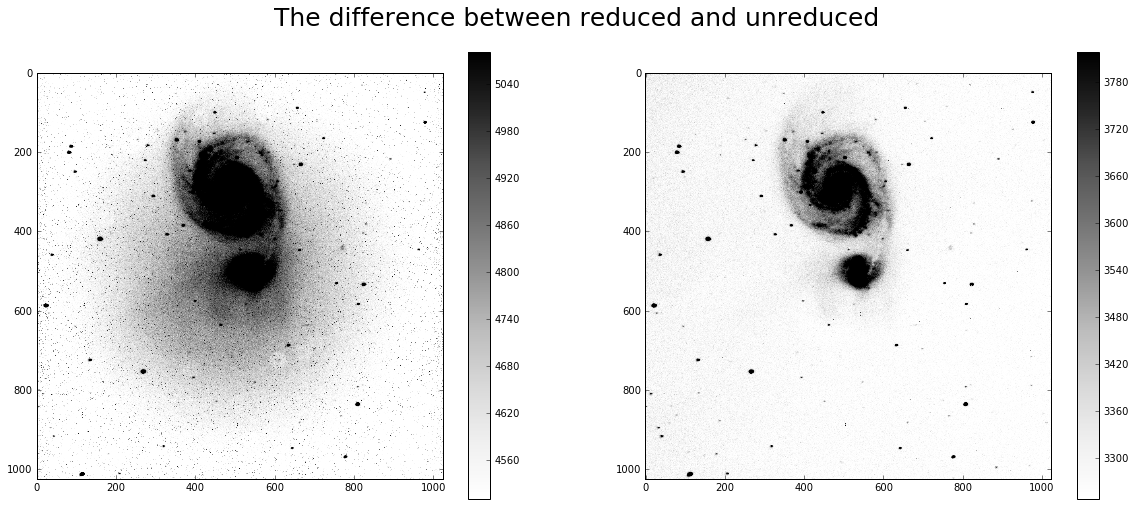

In [44]:
testnum=0
nstd=10
unreduced=pyfits.getdata(science_filenames[testnum])
plt.figure(figsize=(20,8))
plt.subplot(121)
vmin_unred=np.median(median_dark)+skylevels[testnum]
plt.imshow(unreduced,cmap='Greys',vmin=vmin_unred,vmax=vmin_unred+nstd*np.sqrt(skylevels[testnum]))
plt.colorbar()
plt.subplot(122)
plt.imshow(science_reduced[testnum],cmap='Greys',vmin=skylevels[testnum],vmax=skylevels[testnum]+nstd*np.sqrt(skylevels[testnum]))
plt.colorbar()
plt.suptitle('The difference between reduced and unreduced',fontsize=25)


In [45]:
def find_object_centroids_filterbysize(img,threshold,minsize):
    labels, num = snd.label(img > threshold, np.ones((3,3)))     # scipy labels/segments the image using a threshold
    centers = snd.center_of_mass(img, labels, range(1,num+1))    # scipy calculates the center of mass on the labeled img
    x = np.array(centers)[:,1]
    y = np.array(centers)[:,0]
    slices=snd.find_objects(labels)
    xs=np.array([objlabel[1].stop-objlabel[1].start for objlabel in slices])  # takes the min and max label slices
    ys=np.array([objlabel[0].stop-objlabel[0].start for objlabel in slices])  #  to find a rough object size

    maxsize=20    # I hardcoded this in so that some spurious objects would be skipped. Change/delete if you like
    bigenough=np.where((xs>minsize) & (ys>minsize) & (xs<maxsize) & (ys<maxsize))
    xc,yc=x[bigenough],y[bigenough]
    xs,ys=xs[bigenough],ys[bigenough]
    
    print str(len(xc))+' objects found'
    return xc,yc,xs,ys

80 objects found


[0, 1024, 0, 1024]

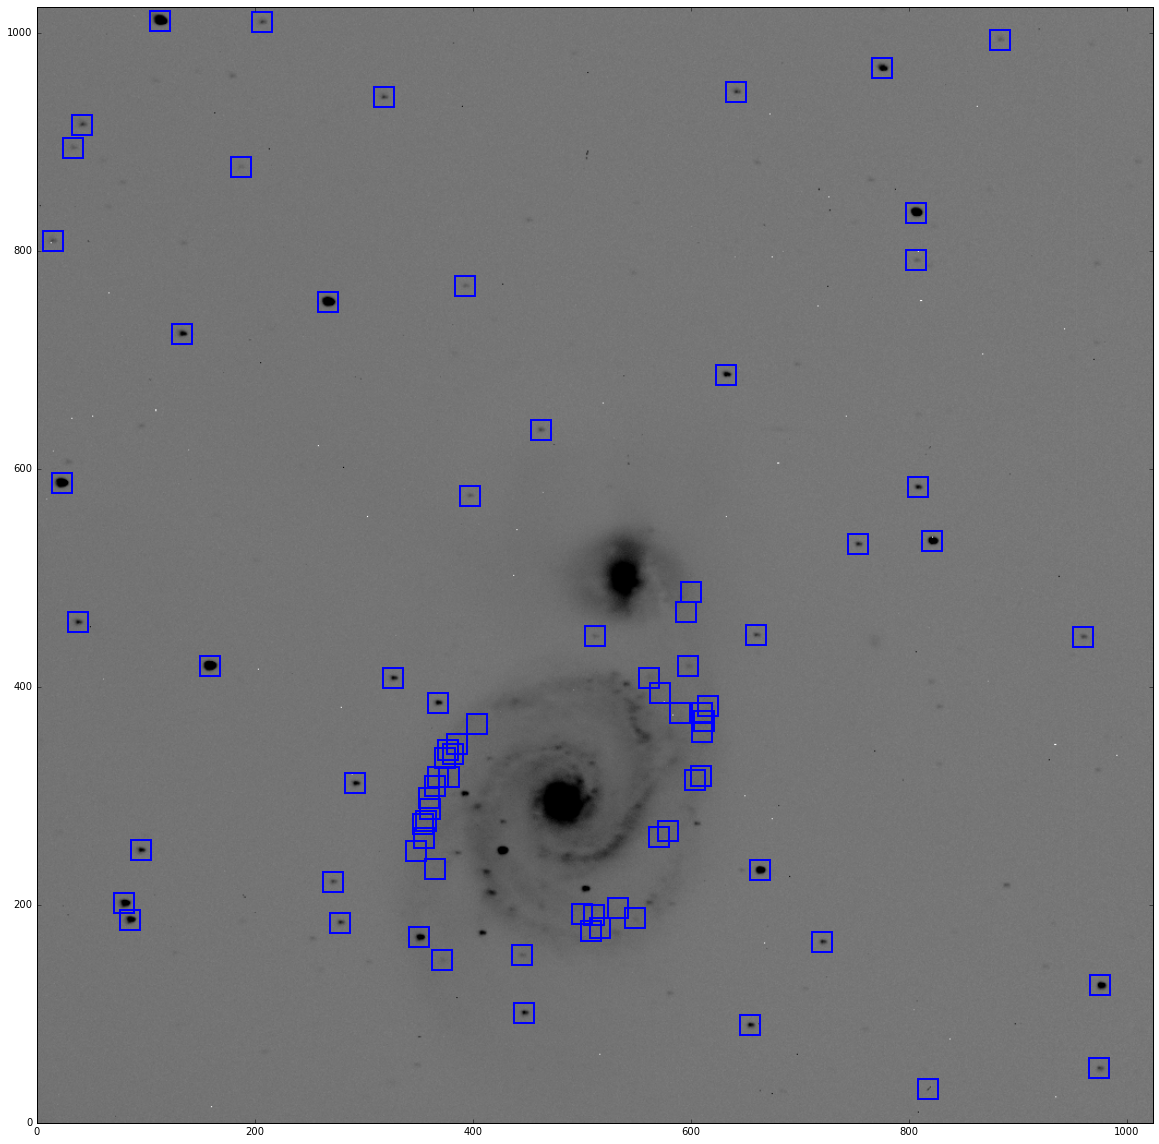

In [46]:
imgnum=0
nstd_aboveskynoise=5
threshold=skylevels[imgnum]+nstd_aboveskynoise*np.sqrt(skylevels[imgnum])   # decide on a threshold using the sky noise
minsize=3

xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[imgnum],threshold,minsize)


plt.figure(figsize=(20,20))
plt.imshow(science_reduced[imgnum],cmap='Greys',vmin=0,vmax=1.5*threshold)
plt.plot(xfoo,yfoo,'rs',mfc='None',markersize=20,markeredgecolor='b',markeredgewidth=2)
plt.axis([0,1024,0,1024])

80 objects found
77 objects found
90 objects found
79 objects found
79 objects found
80 objects found


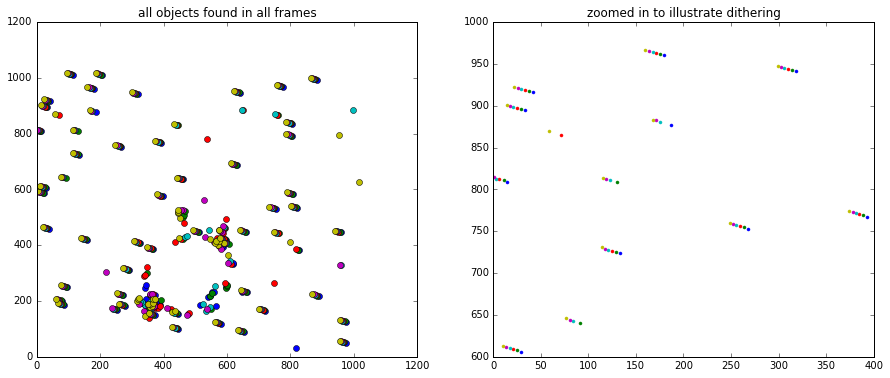

In [47]:
nstd_aboveskynoise=4
thresholds=skylevels+nstd_aboveskynoise*np.sqrt(skylevels)

#thresholds=[threshold]*len(science_reduced)
minsize=3
xc_all,yc_all,xs_all,ys_all=[],[],[],[]
plt.figure(figsize=(15,6))
for i in range(len(science_reduced)):
    xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[i],thresholds[i],minsize)
    xc_all.append(xfoo)
    yc_all.append(yfoo)
    xs_all.append(xsfoo)
    ys_all.append(ysfoo)
    plt.subplot(121)
    plt.plot(xfoo,yfoo,'o')
    plt.subplot(122)
    plt.plot(xfoo,yfoo,'.')
    plt.axis([0,400,600,1000])
plt.subplot(121)
plt.title('all objects found in all frames')
plt.subplot(122)
plt.title('zoomed in to illustrate dithering')

In [48]:
def find_closest(xc0,yc0,xc1,yc1,dr):
    nobjs1=len(xc1)
    x_off,y_off=[],[]
    for i in range(nobjs1):
        poss_match=np.where(np.sqrt((xc1[i]-xc0)**2+(yc1[i]-yc0)**2)<dr)[0]  # for each object in the second catalog, 
        x_off.extend([(xc1[i]-xc0[j]) for j in poss_match])                  #  find matches within a radius dr
        y_off.extend([(yc1[i]-yc0[j]) for j in poss_match])
    x_off=np.array(x_off)
    y_off=np.array(y_off)
    
    n_xoff,xfoo=np.histogram(x_off,bins=dr*2,range=[-dr,dr])   # histogram all the offsets to find the maximum value
    n_yoff,yfoo=np.histogram(y_off,bins=dr*2,range=[-dr,dr])   #  which corresponds to the rough offset between frames
    x_peak=(xfoo[np.where(n_xoff==np.max(n_xoff))])[0]+(xfoo[1]-xfoo[0])/2.
    y_peak=(yfoo[np.where(n_yoff==np.max(n_yoff))])[0]+(yfoo[1]-yfoo[0])/2.   # (note addition of half bin width)
    return x_off,y_off,x_peak,y_peak


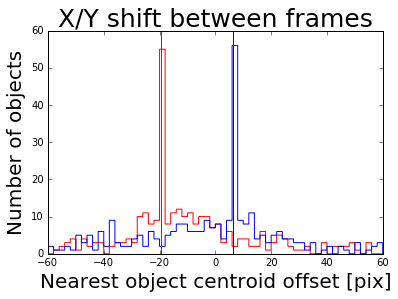

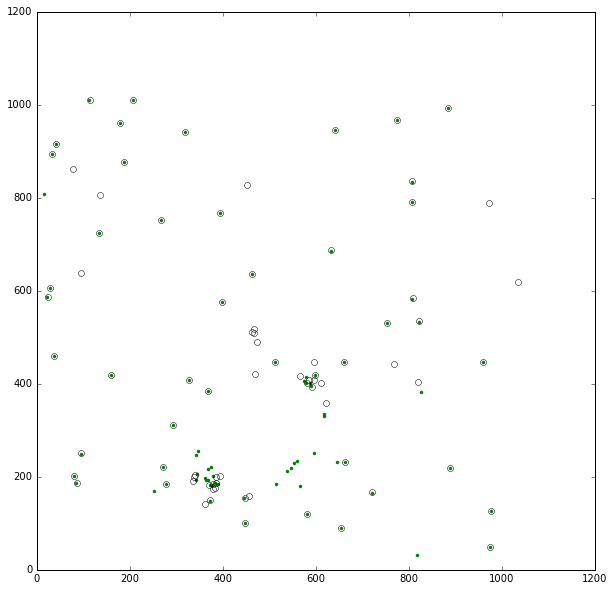

In [49]:
secondnum=5
dr=60
xc0,yc0,xc1,yc1=xc_all[0],yc_all[0],xc_all[secondnum],yc_all[secondnum]
xoff,yoff,xpeak,ypeak=find_closest(xc0,yc0,xc1,yc1,dr)
 
    
plt.hist(xoff,histtype='step',label='x offset',range=[-dr,dr],bins=dr,color='r')
plt.hist(yoff,histtype='step',label='y offset',range=[-dr,dr],bins=dr,color='b')

plt.axvline(xpeak,color='r')
plt.axvline(ypeak,color='b')

plt.xlabel('Nearest object centroid offset [pix]',fontsize=20)
plt.ylabel('Number of objects',fontsize=20)
plt.title('X/Y shift between frames',fontsize=25)

plt.figure(figsize=(10,10))
plt.plot(xc0,yc0,'g.')
plt.plot(xc1-xpeak,yc1-ypeak,'o',mfc='None')


In [50]:
def find_frame_shifts(x0,y0,x1,y1,dr0,nsteps):    #like the def above, take in two sets of coordinates
    xshifts,yshifts=0,0
    drs=[dr0,20,10,5,2.5,1.25]
    for i in range(nsteps):
        dr=dr0/(1.+i)      # slowly reduce the matching radius, to get rid of outliers
        xoff,yoff,xpeak,ypeak=find_closest(x0,y0,x1-xshifts,y1-yshifts,dr)
        n_xoff,xfoo=np.histogram(xoff,bins=50,range=[-dr,dr])
        n_yoff,yfoo=np.histogram(yoff,bins=50,range=[-dr,dr])
        #axvline(xpeak)
        #print xpeak
        if i==0:
            xshift,yshift=xpeak,ypeak    # the first rough offset estimate is the peak of the offset histogram
        else:                            # successive offsets are found by taking the median value of the remainder
            xshift,yshift=np.median(xoff[np.abs(xoff)<dr/2.]),np.median(yoff[np.abs(yoff)<dr/2.])
        xshifts+=xshift        # add in each successive offset to the total
        yshifts+=yshift
        print dr,xshifts,yshifts
        #plot(xshifts,yshifts,'o')
    plt.hist(xoff,histtype='step',color='r',bins=50)
    plt.hist(yoff,histtype='step',color='b',bins=50)
    #plot(yfoo[1:],n_yoff,'b')
    plt.axvline(xshift,color='r')
    plt.axvline(yshift,color='b')
    return xshifts,yshifts

60.0 -19.5 6.5
30.0 -18.9935243257 6.73131144164
20.0 -19.0470863782 6.72898333058
15.0 -19.0702040868 6.75133374073
12.0 -19.0966880429 6.74939864458
10.0 -19.0785609279 6.74151909864


(-19.078560927905343, 6.7415190986441189)

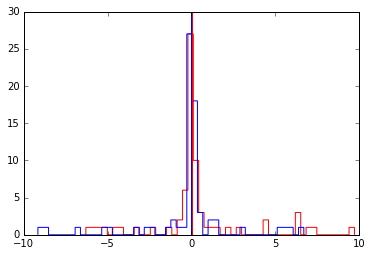

In [51]:
firstnum,secondnum=0,-1
dr=60
xc0,yc0,xc1,yc1=xc_all[firstnum],yc_all[firstnum],xc_all[secondnum],yc_all[secondnum]
find_frame_shifts(xc0,yc0,xc1,yc1,dr,6)

60.0 -3.5 1.5
30.0 -3.9814912291 1.47998035021
20.0 -3.98520167578 1.48327210054
15.0 -3.98520167578 1.47008189385
60.0 -8.5 2.5
30.0 -8.41762903291 2.75249257855
20.0 -8.4600262218 2.79167629344
15.0 -8.51496552093 2.7730067039
60.0 -12.5 3.5
30.0 -12.1138116933 3.85456650977
20.0 -12.15432764 3.91619072322
15.0 -12.1481515403 3.89429515545
60.0 -15.5 5.5
30.0 -15.4818848756 5.42201798215
20.0 -15.5733677623 5.42691549092
15.0 -15.5787379193 5.43703477048
60.0 -19.5 6.5
30.0 -18.9935243257 6.73131144164
20.0 -19.0470863782 6.72898333058
15.0 -19.0702040868 6.75133374073


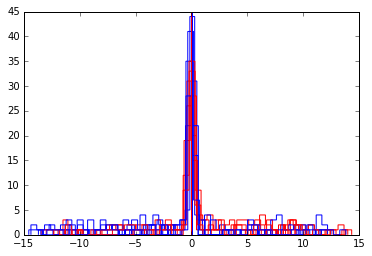

In [52]:
xshifts,yshifts=np.zeros(len(science_reduced)),np.zeros(len(science_reduced))
for secondnum in range(1,len(science_reduced)):
    xshifts[secondnum],yshifts[secondnum]=find_frame_shifts(xc_all[0],yc_all[0],xc_all[secondnum],yc_all[secondnum],dr,4)


In [53]:
science_shifted_rescaled=np.array([snd.interpolation.shift(science_reduced[i],[-yshifts[i],-xshifts[i]],order=5) for i in range(0,len(science_reduced))])
stackedimg=np.median(science_shifted_rescaled,axis=0)-np.median(skylevels)

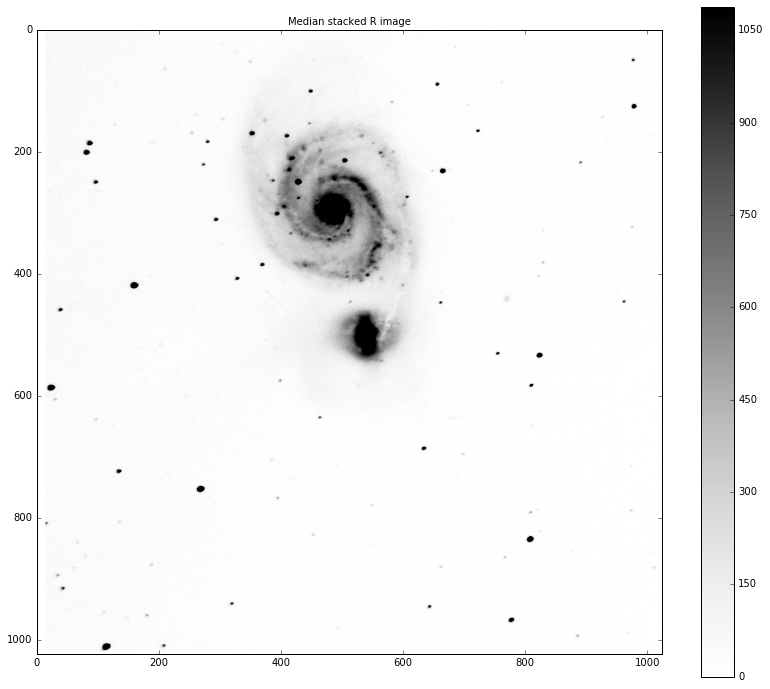

In [54]:
plt.figure(figsize=(14,12))
plt.title('Median stacked '+thefilt+' image',fontsize=10)
plt.imshow(stackedimg,cmap='Greys',vmin=0,vmax=20*np.sqrt(np.median(skylevels)))
plt.colorbar()
#plt.axis([200,700,200,700])
pyfits.writeto(rootdir+thefilt+'-median.fits',stackedimg,clobber=True)

In [55]:
new_stackedimag=stackedimg*.03
pyfits.writeto('/Users/noahknoblauch/PHY157/Observing/Ratio_Stacked_R.FITS',new_stackedimag,clobber=True)

//anaconda/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/Users/noahknoblauch/PHY157/Observing/Ratio_Stacked_R.FITS'.
  warnings.warn("Overwriting existing file %r." % self.name)


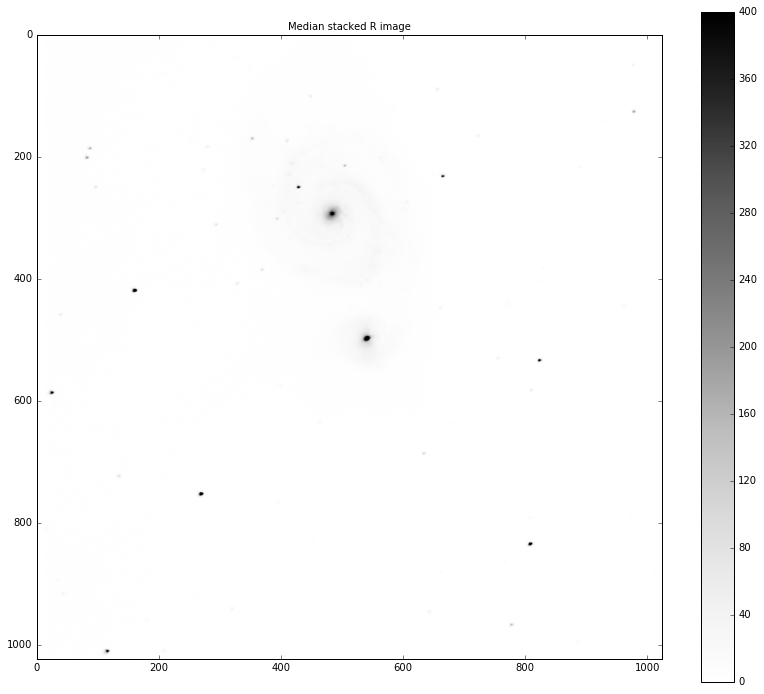

In [56]:
plt.figure(figsize=(14,12))
plt.title('Median stacked '+thefilt+' image',fontsize=10)
plt.imshow(new_stackedimag,cmap='Greys',vmin=0,vmax=400)
plt.colorbar()
#plt.axis([200,700,200,700])
pyfits.writeto(rootdir+thefilt+'-median.fits',stackedimg,clobber=True)

8


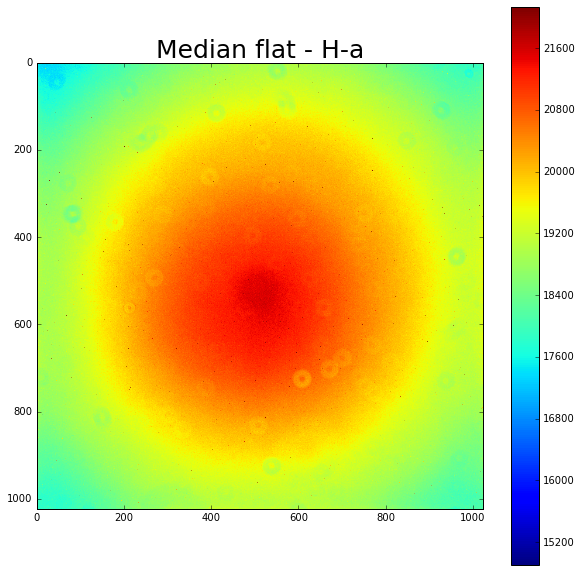

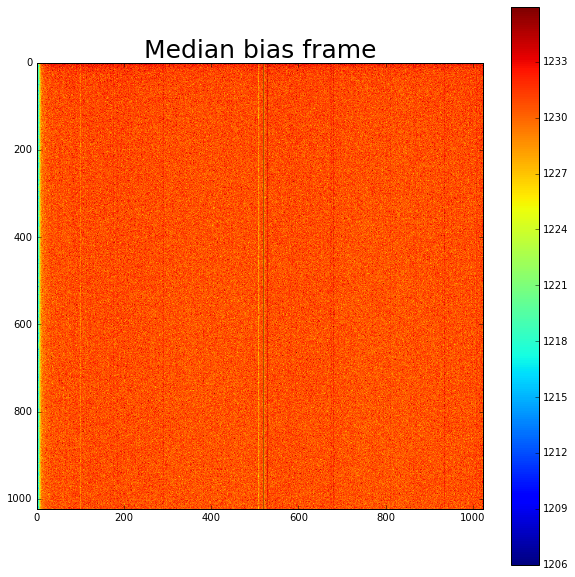

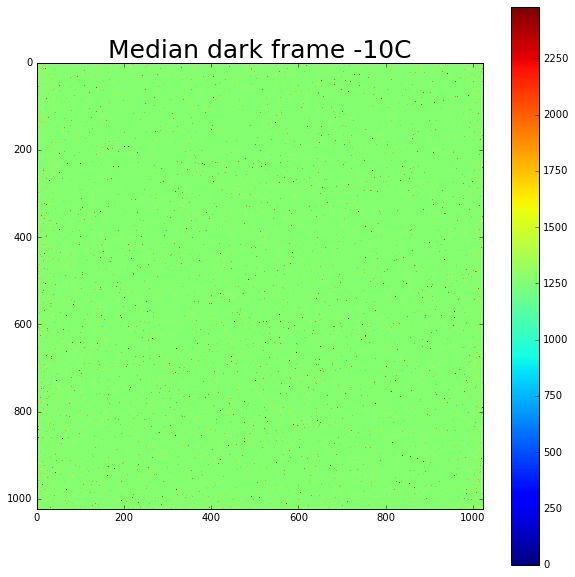

In [92]:
thefilt='H-a'
flat_time=90
dark_time=300


median_dark=median_combine(dark_filenames[:][np.where((dark_exptimes==dark_time))])

median_flat=median_combine(flat_filenames[np.where((flat_filter_names==thefilt) & 
                                                             (flat_exptimes==flat_time))])
median_bias=median_combine(bias_filenames[:50])   # note that I take only the first 50 biases, to save time


print len(flat_filenames[np.where((flat_filter_names==thefilt) & 
                                                             (flat_exptimes==flat_time))])

plt.figure(figsize=(10,10))
plt.imshow(median_flat,vmax=np.median(median_flat)+3*np.std(median_flat))
plt.title('Median flat - '+thefilt,fontsize=25)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(median_bias,vmax=np.median(median_bias)+3*np.std(median_bias))
plt.title('Median bias frame',fontsize=25)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(median_dark,vmax=np.median(median_dark)+3*np.std(median_dark))
plt.title('Median dark frame -10C',fontsize=25)
plt.colorbar()

[ '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000002.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000003.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000004.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000005.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000006.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000007.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000008.M_51.FIT']
[ 300.  300.  300.  300.  300.  300.  300.]


//anaconda/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000002.M_51-reduced.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
//anaconda/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000003.M_51-reduced.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
//anaconda/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000004.M_51-reduced.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
//anaconda/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/M51/M51_Ha_300s.00000005.M_51-redu

[74.0, 74.0, 80.0, 80.0, 80.0, 86.0, 86.0]


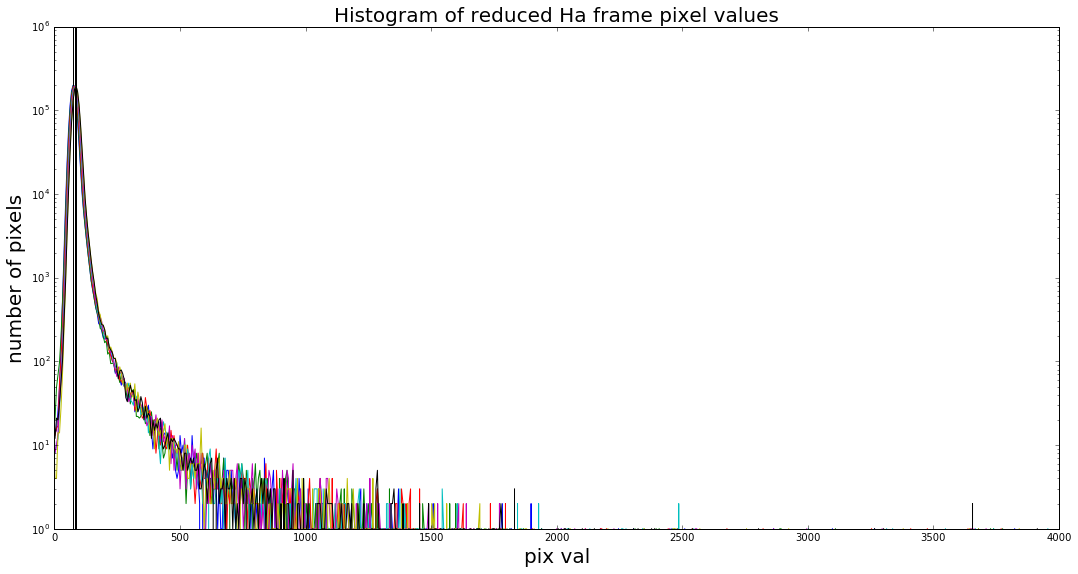

In [79]:
m51_time=300
science_filenames=np.sort(m51_filenames[np.where((m51_filter_names==thefilt) & (m51_exptimes==m51_time))])[1:]
science_filenames=science_filenames
print science_filenames
science_reduced = reduce_raw_science_frames(science_filenames,median_bias,median_flat,median_dark)
science_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in science_filenames])
print science_exptimes
for i in range(len(science_reduced)):
    pyfits.writeto(science_filenames[i].split('.FIT')[0]+'-reduced.fits',science_reduced[i],
                   clobber=True,header=pyfits.getheader(science_filenames[i]))

plt.figure(figsize=(18,9))
skylevels=[]
for i in range(len(science_reduced)):
    numpix,aduvals=np.histogram(science_reduced[i].flatten(),bins=1000,range=[-1000,5e3])
    skylevel=aduvals[np.where(numpix==numpix.max())][0]
    skylevels.append(skylevel)
    plt.plot(aduvals[:-1],numpix)
    plt.axvline(skylevel,color='k')
plt.xlabel('pix val',fontsize=20)
plt.ylabel('number of pixels',fontsize=20)
plt.yscale('log')

plt.xlim(0,4000)

print skylevels
plt.title('Histogram of reduced Ha frame pixel values',fontsize=20)

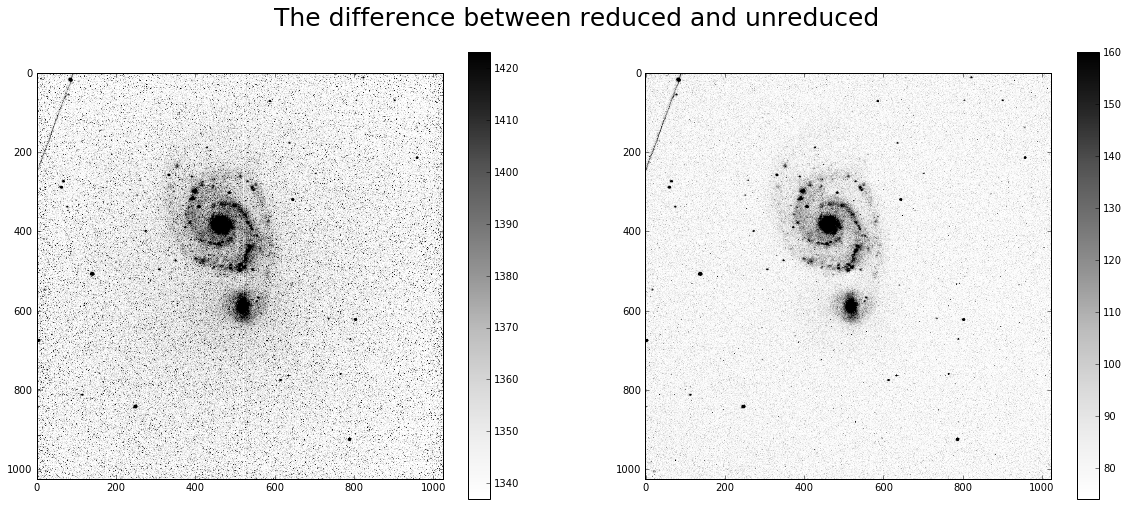

In [80]:
testnum=0
nstd=10
unreduced=pyfits.getdata(science_filenames[testnum])
plt.figure(figsize=(20,8))
plt.subplot(121)
vmin_unred=np.median(median_dark)+skylevels[testnum]
plt.imshow(unreduced,cmap='Greys',vmin=vmin_unred,vmax=vmin_unred+nstd*np.sqrt(skylevels[testnum]))
plt.colorbar()
plt.subplot(122)
plt.imshow(science_reduced[testnum],cmap='Greys',vmin=skylevels[testnum],vmax=skylevels[testnum]+nstd*np.sqrt(skylevels[testnum]))
plt.colorbar()
plt.suptitle('The difference between reduced and unreduced',fontsize=25)


112 objects found


[0, 1024, 0, 1024]

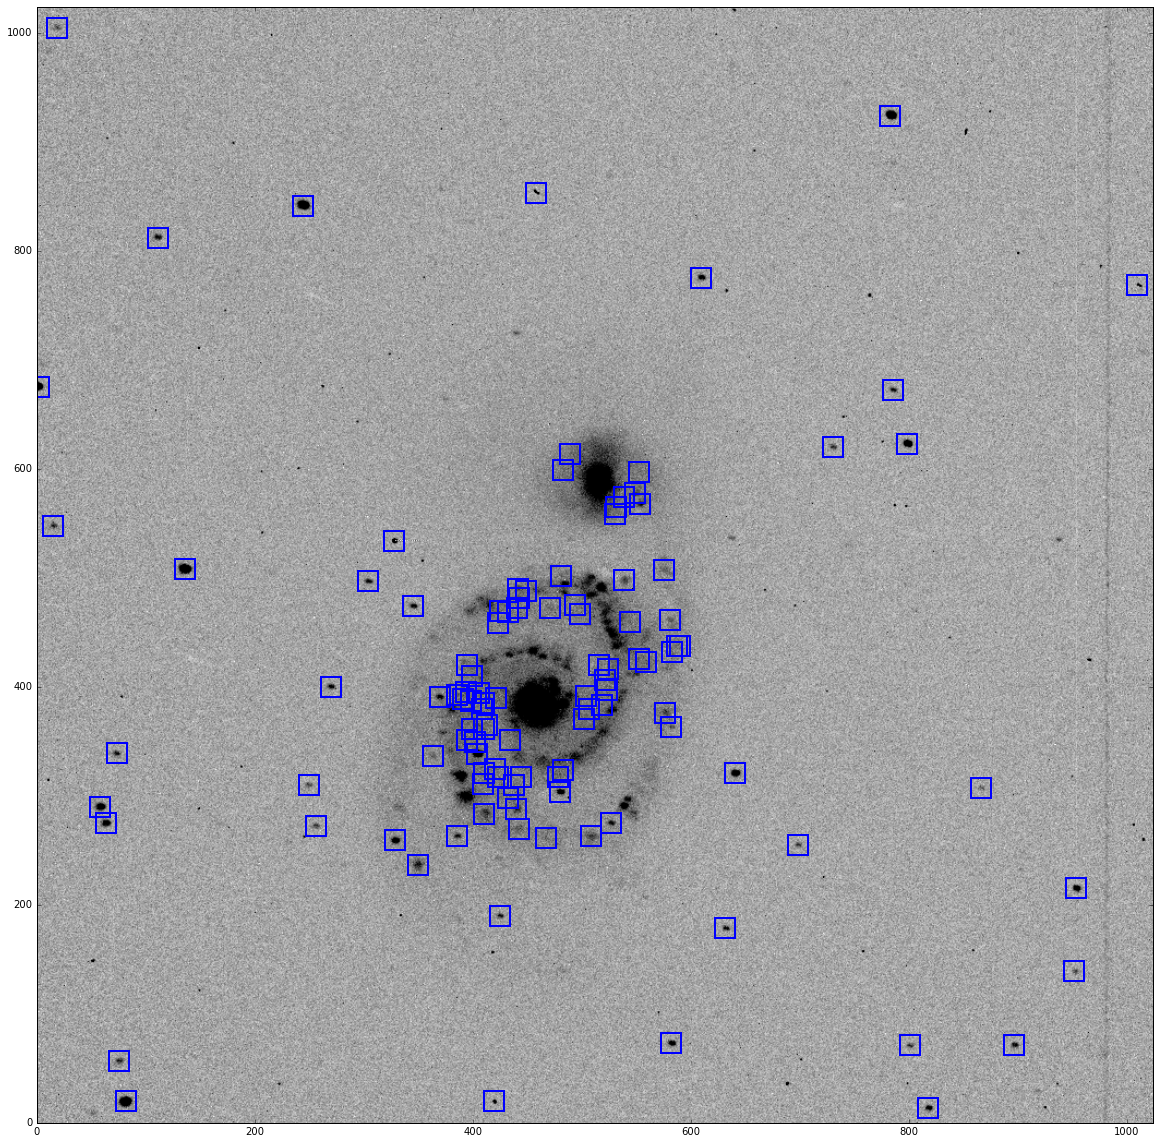

In [81]:
imgnum=1
nstd_aboveskynoise=5
threshold=skylevels[imgnum]+nstd_aboveskynoise*np.sqrt(skylevels[imgnum])   # decide on a threshold using the sky noise
minsize=3

xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[imgnum],threshold,minsize)


plt.figure(figsize=(20,20))
plt.imshow(science_reduced[imgnum],cmap='Greys',vmin=0,vmax=1.5*threshold)
plt.plot(xfoo,yfoo,'rs',mfc='None',markersize=20,markeredgecolor='b',markeredgewidth=2)
plt.axis([0,1024,0,1024])

132 objects found
143 objects found
118 objects found
128 objects found
141 objects found
119 objects found
131 objects found


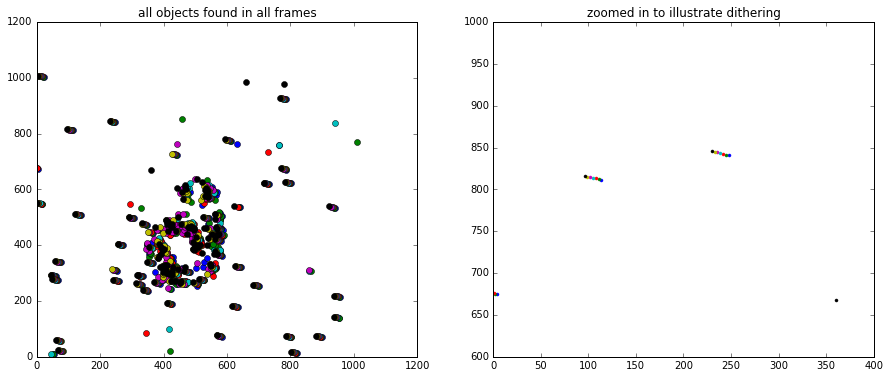

In [82]:
nstd_aboveskynoise=4
thresholds=skylevels+nstd_aboveskynoise*np.sqrt(skylevels)

#thresholds=[threshold]*len(science_reduced)
minsize=3
xc_all,yc_all,xs_all,ys_all=[],[],[],[]
plt.figure(figsize=(15,6))
for i in range(len(science_reduced)):
    xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[i],thresholds[i],minsize)
    xc_all.append(xfoo)
    yc_all.append(yfoo)
    xs_all.append(xsfoo)
    ys_all.append(ysfoo)
    plt.subplot(121)
    plt.plot(xfoo,yfoo,'o')
    plt.subplot(122)
    plt.plot(xfoo,yfoo,'.')
    plt.axis([0,400,600,1000])
plt.subplot(121)
plt.title('all objects found in all frames')
plt.subplot(122)
plt.title('zoomed in to illustrate dithering')

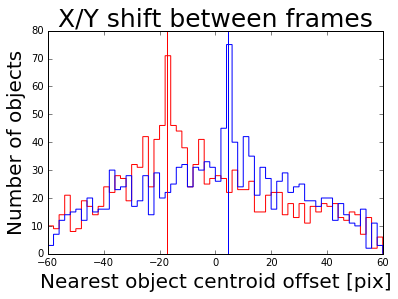

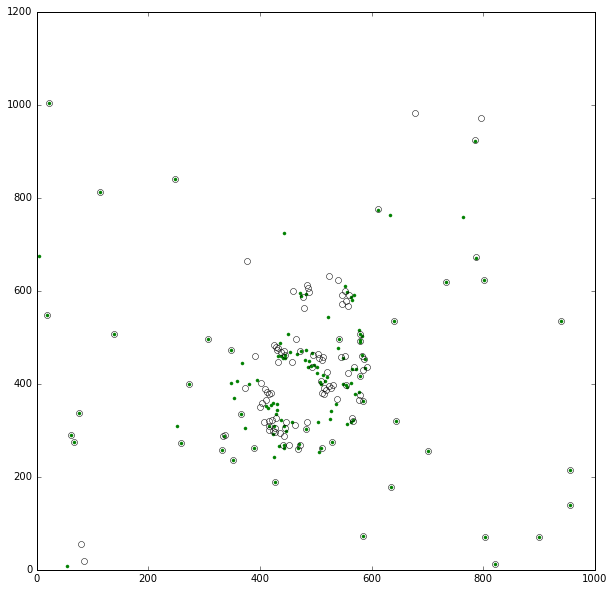

In [83]:
secondnum=6
dr=60
xc0,yc0,xc1,yc1=xc_all[0],yc_all[0],xc_all[secondnum],yc_all[secondnum]
xoff,yoff,xpeak,ypeak=find_closest(xc0,yc0,xc1,yc1,dr)
 
    
plt.hist(xoff,histtype='step',label='x offset',range=[-dr,dr],bins=dr,color='r')
plt.hist(yoff,histtype='step',label='y offset',range=[-dr,dr],bins=dr,color='b')

plt.axvline(xpeak,color='r')
plt.axvline(ypeak,color='b')

plt.xlabel('Nearest object centroid offset [pix]',fontsize=20)
plt.ylabel('Number of objects',fontsize=20)
plt.title('X/Y shift between frames',fontsize=25)

plt.figure(figsize=(10,10))
plt.plot(xc0,yc0,'g.')
plt.plot(xc1-xpeak,yc1-ypeak,'o',mfc='None')

60.0 -17.5 4.5
30.0 -17.3891708345 4.63351279438
20.0 -17.4043335256 4.63318219398
15.0 -17.3934938268 4.63272767519
12.0 -17.3814049061 4.63272767519
10.0 -17.3839252751 4.63318219398


(-17.383925275054665, 4.6331821939769942)

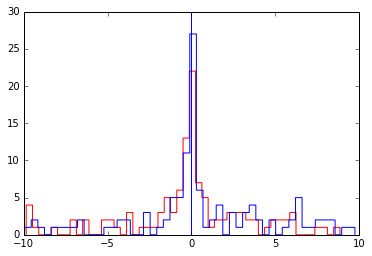

In [84]:
firstnum,secondnum=0,-1
dr=60
xc0,yc0,xc1,yc1=xc_all[firstnum],yc_all[firstnum],xc_all[secondnum],yc_all[secondnum]
find_frame_shifts(xc0,yc0,xc1,yc1,dr,6)

60.0 -2.5 0.5
30.0 -2.67315362498 0.631559768354
20.0 -2.68263308441 0.764184242306
15.0 -2.74297473312 0.689403450487
60.0 -5.5 1.5
30.0 -5.68181626033 1.68469551233
20.0 -5.60452850344 1.64008883424
15.0 -5.5506051797 1.60653943909
60.0 -8.5 2.5
30.0 -8.67487395019 2.66977962674
20.0 -8.86285550745 2.45207213148
15.0 -8.93868921464 2.41265802715
60.0 -12.5 2.5
30.0 -12.2013795002 3.03297641096
20.0 -12.1058574024 3.05215210678
15.0 -12.0528238124 3.04968741171
60.0 -14.5 3.5
30.0 -14.7073039171 3.87422248476
20.0 -14.7855851435 3.98789867077
15.0 -14.7233820018 3.97480424103
60.0 -17.5 4.5
30.0 -17.3891708345 4.63351279438
20.0 -17.4043335256 4.63318219398
15.0 -17.3934938268 4.63272767519


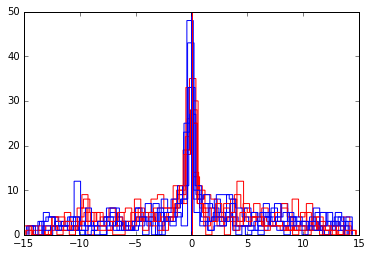

In [85]:
xshifts,yshifts=np.zeros(len(science_reduced)),np.zeros(len(science_reduced))
for secondnum in range(1,len(science_reduced)):
    xshifts[secondnum],yshifts[secondnum]=find_frame_shifts(xc_all[0],yc_all[0],xc_all[secondnum],yc_all[secondnum],dr,4)


In [86]:
science_shifted_rescaled=np.array([snd.interpolation.shift(science_reduced[i],[-yshifts[i],-xshifts[i]],order=5) for i in range(0,len(science_reduced))])
Ha_stackedimg=np.median(science_shifted_rescaled,axis=0)-np.median(skylevels)

//anaconda/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160524/H-a-median.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


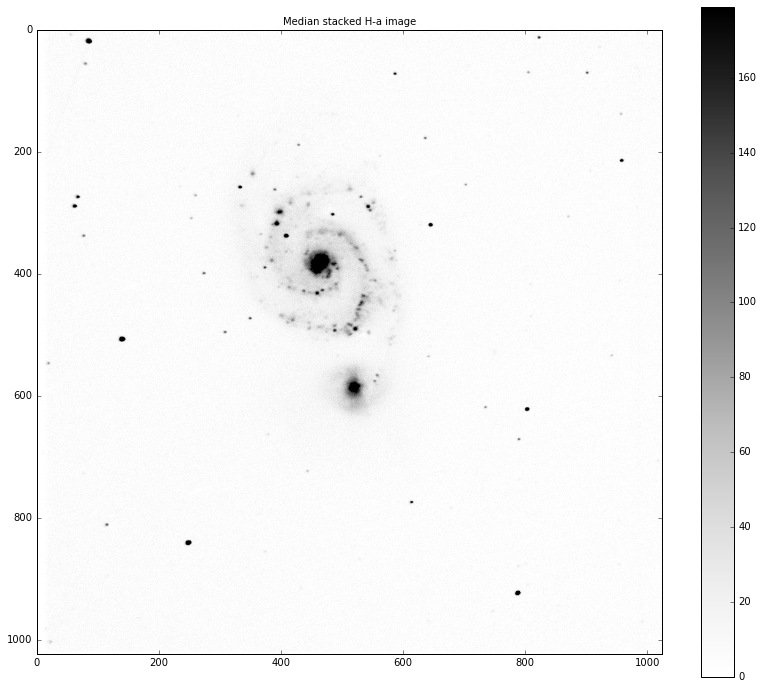

In [87]:
plt.figure(figsize=(14,12))
plt.title('Median stacked '+thefilt+' image',fontsize=10)
plt.imshow(stackedimg,cmap='Greys',vmin=0,vmax=20*np.sqrt(np.median(skylevels)))
plt.colorbar()
#plt.axis([200,700,200,700])
pyfits.writeto(rootdir+thefilt+'-median.fits',stackedimg,clobber=True)

In [90]:
pyfits.writeto('/Users/noahknoblauch/PHY157/Observing/Ha_staked_img.FITS',Ha_stackedimg,clobber=True)

//anaconda/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/Users/noahknoblauch/PHY157/Observing/Ha_staked_img.FITS'.
  warnings.warn("Overwriting existing file %r." % self.name)
